In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv('final_less_stopwords.csv')

In [3]:
data['text'] = data['text'].str.replace("[^a-zA-Z#]", " ")

<ipython-input-3-2a58f03204e6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace("[^a-zA-Z#]", " ")


In [4]:
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

In [5]:
data.isna().any()

Unnamed: 0    False
text           True
sentiment     False
dtype: bool

In [6]:
data = data.dropna()

In [7]:
data.isna().any()

Unnamed: 0    False
text          False
sentiment     False
dtype: bool

In [8]:
data['text'] = np.vectorize(remove_pattern)(data['text'], "@[\w]*")

In [9]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [10]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  259,  108,  130,  189,  531,  513,
          4,  850,  162, 1194,  686])

In [11]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 38, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 38, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9897, 38) (9897, 2)
(4875, 38) (4875, 2)


In [13]:
# train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

batch_size = 32
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, validation_data=(X_test, Y_test), callbacks=[early_stopping])

Epoch 1/10
310/310 [==============================] - 53s 162ms/step - loss: 0.4338 - accuracy: 0.8072 - val_loss: 0.3626 - val_accuracy: 0.8459
Epoch 2/10
310/310 [==============================] - 50s 163ms/step - loss: 0.3091 - accuracy: 0.8754 - val_loss: 0.3565 - val_accuracy: 0.8542
Epoch 3/10
310/310 [==============================] - 50s 163ms/step - loss: 0.2661 - accuracy: 0.8931 - val_loss: 0.3773 - val_accuracy: 0.8519
Epoch 4/10
310/310 [==============================] - 52s 169ms/step - loss: 0.2343 - accuracy: 0.9068 - val_loss: 0.4021 - val_accuracy: 0.8523


In [14]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

106/106 - 2s - loss: 0.4162 - accuracy: 0.8477 - 2s/epoch - 20ms/step
score: 0.42
acc: 0.85


In [15]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 360ms/epoch - 360ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 3

1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 68ms/epoch - 68ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31m

1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 33m

1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 33m

1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 35m

1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35m

1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 39m

In [16]:
twt = ['humanda kayu evaluation ocap chors cancelassignmenttab']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=0,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")
    

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 - 0s - 399ms/epoch - 399ms/step
negative


In [19]:
import matplotlib.pyplot as plt
# num_epochs = 7
# history = model.fit(X_train, Y_train, epochs=num_epochs, validation_data=(X_test, Y_test))




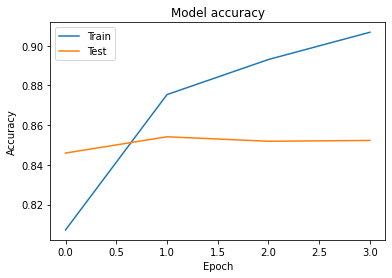

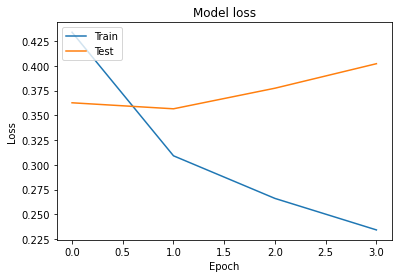

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
data.to_csv('SUPER_DATA.csv')